<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Wed Dec 17 10:40:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 591.44                 Driver Version: 591.44         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   36C    P8             29W /  320W |    1506MiB /  16376MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.9.1+cu128


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

Train dataset 



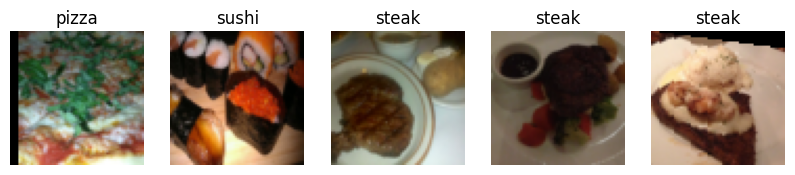

test_dataset 



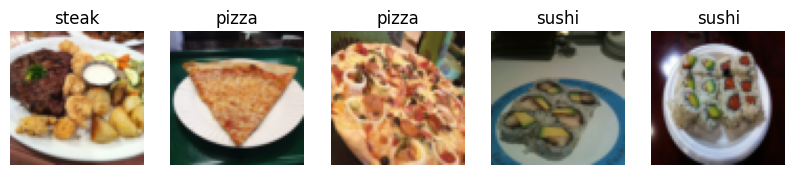

In [20]:
# 1. Get data
import torchvision
from pathlib import Path
import random
import matplotlib.pyplot as plt
dataPath = Path.cwd().parent.parent /  'data' / 'pizza_steak_sushi'
train_data = dataPath / 'train'
test_data = dataPath / 'test'


train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize([64, 64]),
    torchvision.transforms.TrivialAugmentWide(),
    torchvision.transforms.ToTensor()
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize([64,64]),
    torchvision.transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(train_data, transform=train_transforms, allow_empty=False)
test_dataset = torchvision.datasets.ImageFolder(test_data, transform=test_transforms, allow_empty=False)

def visualize_dataset(dataset : torch.utils.data.Dataset, n:int, seed:int=42):
    torch.manual_seed(seed)
    rand_indices = torch.randint(0, len(dataset), [n,]).cpu().tolist()
    plt.figure(figsize=(10,10)) 
    for i, rand_ind in enumerate(rand_indices):
        data, label = dataset[rand_ind]
        

        plt.subplot(1, n, i+1)
        plt.imshow(data.permute(1,2,0))
        plt.title(dataset.classes[label])
        plt.axis('Off')
    
    plt.show()
print('Train dataset \n')
visualize_dataset(train_dataset, 5)
print('test_dataset \n')
visualize_dataset(test_dataset, 5)


In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [21]:
# Turn train and test Datasets into DataLoaders
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() 
train_dataloader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [28]:
# How many batches of images are in our data loaders?
print(next(iter(train_dataloader))[0].shape)

torch.Size([32, 3, 64, 64])


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [34]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):

        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_dataset.classes)).to(device)

from torchinfo import summary
summary(model_0, input_size=[32,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

## 4. Create training and testing functions for `model_0`.

In [50]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X = X.to(device)
    y = y.to(device)
    # 1. Forward pass
    y_pred = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    train_loss += loss.item()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += ((y_pred_class == y).sum().item() / len(y))


  # Adjust metrics to get average loss and average accuracy per batch

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [51]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X,y) in enumerate(dataloader):
      # Send data to target device
      X = X.to(device)
      y = y.to(device)
      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(y_pred, y)

      # Calculate and accumulate accuracy
      test_loss += loss.item()
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      test_acc += ((y_pred_class == y).sum().item() / len(y))
    
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss/ len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss,  test_acc

In [52]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [49]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), 
                             lr=0.001)

train(model_0, train_dataloader, test_dataloader, optimizer, loss_fn, 5)




 20%|██        | 1/5 [00:11<00:47, 11.77s/it]

Epoch: 1 | train_loss: 1.1035 | train_acc: 0.2500 | test_loss: 1.0946 | test_acc: 0.4119


 40%|████      | 2/5 [00:23<00:34, 11.64s/it]

Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4297 | test_loss: 1.1108 | test_acc: 0.2604


 60%|██████    | 3/5 [00:34<00:23, 11.60s/it]

Epoch: 3 | train_loss: 1.0733 | train_acc: 0.4258 | test_loss: 1.1427 | test_acc: 0.2604


 80%|████████  | 4/5 [00:46<00:11, 11.55s/it]

Epoch: 4 | train_loss: 1.0935 | train_acc: 0.3086 | test_loss: 1.1520 | test_acc: 0.3125


100%|██████████| 5/5 [00:57<00:00, 11.59s/it]

Epoch: 5 | train_loss: 1.0640 | train_acc: 0.5195 | test_loss: 1.1369 | test_acc: 0.2708


{'train_loss': [1.1034909635782242,
  1.0845609307289124,
  1.0732908621430397,
  1.093519076704979,
  1.0640293508768082],
 'train_acc': [0.25, 0.4296875, 0.42578125, 0.30859375, 0.51953125],
 'test_loss': [tensor(1.0946, device='cuda:0'),
  tensor(1.1108, device='cuda:0'),
  tensor(1.1427, device='cuda:0'),
  tensor(1.1520, device='cuda:0'),
  tensor(1.1369, device='cuda:0')],
 'test_acc': [0.4119318181818182,
  0.2604166666666667,
  0.2604166666666667,
  0.3125,
  0.2708333333333333]}

In [54]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_dataset.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), 
                             lr=0.001)

train(model_1, train_dataloader, test_dataloader, optimizer, loss_fn, 20)


  5%|▌         | 1/20 [00:11<03:40, 11.62s/it]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1375 | test_acc: 0.2604


 10%|█         | 2/20 [00:23<03:28, 11.58s/it]

Epoch: 2 | train_loss: 1.0829 | train_acc: 0.4258 | test_loss: 1.1671 | test_acc: 0.1979


 15%|█▌        | 3/20 [00:35<03:21, 11.87s/it]

Epoch: 3 | train_loss: 1.1211 | train_acc: 0.2930 | test_loss: 1.1731 | test_acc: 0.1979


 20%|██        | 4/20 [00:47<03:11, 11.98s/it]

Epoch: 4 | train_loss: 1.0959 | train_acc: 0.4141 | test_loss: 1.1405 | test_acc: 0.1979


 25%|██▌       | 5/20 [00:59<02:58, 11.93s/it]

Epoch: 5 | train_loss: 1.0941 | train_acc: 0.2930 | test_loss: 1.1442 | test_acc: 0.1979


 30%|███       | 6/20 [01:11<02:46, 11.89s/it]

Epoch: 6 | train_loss: 1.0958 | train_acc: 0.3203 | test_loss: 1.1503 | test_acc: 0.2604


 35%|███▌      | 7/20 [01:22<02:33, 11.83s/it]

Epoch: 7 | train_loss: 1.1139 | train_acc: 0.3359 | test_loss: 1.1341 | test_acc: 0.1979


 40%|████      | 8/20 [01:34<02:21, 11.79s/it]

Epoch: 8 | train_loss: 1.0954 | train_acc: 0.3125 | test_loss: 1.0977 | test_acc: 0.2292


 45%|████▌     | 9/20 [01:46<02:10, 11.83s/it]

Epoch: 9 | train_loss: 1.0851 | train_acc: 0.4805 | test_loss: 1.0777 | test_acc: 0.5833


 50%|█████     | 10/20 [01:58<01:57, 11.73s/it]

Epoch: 10 | train_loss: 1.0766 | train_acc: 0.4570 | test_loss: 1.0590 | test_acc: 0.5729


 55%|█████▌    | 11/20 [02:09<01:45, 11.74s/it]

Epoch: 11 | train_loss: 1.0616 | train_acc: 0.4492 | test_loss: 1.0338 | test_acc: 0.5833


 60%|██████    | 12/20 [02:21<01:34, 11.79s/it]

Epoch: 12 | train_loss: 1.0452 | train_acc: 0.5078 | test_loss: 1.0424 | test_acc: 0.3617


 65%|██████▌   | 13/20 [03:03<02:27, 21.03s/it]

Epoch: 13 | train_loss: 1.1100 | train_acc: 0.4336 | test_loss: 1.0814 | test_acc: 0.3816


 70%|███████   | 14/20 [04:01<03:12, 32.06s/it]

Epoch: 14 | train_loss: 0.9643 | train_acc: 0.5703 | test_loss: 1.0256 | test_acc: 0.3722


 75%|███████▌  | 15/20 [04:59<03:18, 39.73s/it]

Epoch: 15 | train_loss: 1.0114 | train_acc: 0.4531 | test_loss: 0.9930 | test_acc: 0.4441


 80%|████████  | 16/20 [05:56<03:00, 45.05s/it]

Epoch: 16 | train_loss: 0.9101 | train_acc: 0.6367 | test_loss: 1.0502 | test_acc: 0.3627


 85%|████████▌ | 17/20 [06:53<02:26, 48.73s/it]

Epoch: 17 | train_loss: 1.0088 | train_acc: 0.5625 | test_loss: 0.9992 | test_acc: 0.3419


 90%|█████████ | 18/20 [07:52<01:43, 51.64s/it]

Epoch: 18 | train_loss: 0.9772 | train_acc: 0.4336 | test_loss: 0.9942 | test_acc: 0.3826


 95%|█████████▌| 19/20 [08:49<00:53, 53.31s/it]

Epoch: 19 | train_loss: 0.9761 | train_acc: 0.4766 | test_loss: 0.9412 | test_acc: 0.5246


100%|██████████| 20/20 [09:46<00:00, 29.35s/it]

Epoch: 20 | train_loss: 1.0242 | train_acc: 0.4766 | test_loss: 0.9386 | test_acc: 0.5341


{'train_loss': [1.1078176349401474,
  1.082912415266037,
  1.1211358606815338,
  1.0958972722291946,
  1.094116896390915,
  1.0958360880613327,
  1.1138509511947632,
  1.0953704863786697,
  1.0850509107112885,
  1.076636016368866,
  1.0616404563188553,
  1.0452474281191826,
  1.110028475522995,
  0.9643243104219437,
  1.0113641992211342,
  0.9101450890302658,
  1.008778415620327,
  0.9771976694464684,
  0.9760529175400734,
  1.0241549089550972],
 'train_acc': [0.2578125,
  0.42578125,
  0.29296875,
  0.4140625,
  0.29296875,
  0.3203125,
  0.3359375,
  0.3125,
  0.48046875,
  0.45703125,
  0.44921875,
  0.5078125,
  0.43359375,
  0.5703125,
  0.453125,
  0.63671875,
  0.5625,
  0.43359375,
  0.4765625,
  0.4765625],
 'test_loss': [1.1374539931615193,
  1.167057196299235,
  1.1731057564417522,
  1.1404848496119182,
  1.144175132115682,
  1.1502583026885986,
  1.134142557779948,
  1.0977086226145427,
  1.0776686668395996,
  1.0590063134829204,
  1.0338416298230488,
  1.0424481431643169,


In [55]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_dataset.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), 
                             lr=0.001)

train(model_1, train_dataloader, test_dataloader, optimizer, loss_fn, 50)

  2%|▏         | 1/50 [00:15<12:55, 15.82s/it]

Epoch: 1 | train_loss: 0.8707 | train_acc: 0.6328 | test_loss: 0.9386 | test_acc: 0.5341


  4%|▍         | 2/50 [00:27<10:37, 13.28s/it]

Epoch: 2 | train_loss: 1.1105 | train_acc: 0.4922 | test_loss: 0.9386 | test_acc: 0.5341


  6%|▌         | 3/50 [00:38<09:45, 12.46s/it]

Epoch: 3 | train_loss: 0.9943 | train_acc: 0.5039 | test_loss: 0.9386 | test_acc: 0.5341


  8%|▊         | 4/50 [00:50<09:13, 12.03s/it]

Epoch: 4 | train_loss: 0.8997 | train_acc: 0.5781 | test_loss: 0.9386 | test_acc: 0.5341


 10%|█         | 5/50 [01:01<08:50, 11.78s/it]

Epoch: 5 | train_loss: 0.9213 | train_acc: 0.6016 | test_loss: 0.9386 | test_acc: 0.5341


 12%|█▏        | 6/50 [01:12<08:33, 11.66s/it]

Epoch: 6 | train_loss: 0.9615 | train_acc: 0.4609 | test_loss: 0.9386 | test_acc: 0.5341


 14%|█▍        | 7/50 [01:24<08:16, 11.54s/it]

Epoch: 7 | train_loss: 0.9329 | train_acc: 0.6289 | test_loss: 0.9386 | test_acc: 0.5341


 16%|█▌        | 8/50 [01:35<08:00, 11.45s/it]

Epoch: 8 | train_loss: 0.9069 | train_acc: 0.4961 | test_loss: 0.9386 | test_acc: 0.5341


 18%|█▊        | 9/50 [01:47<07:53, 11.55s/it]

Epoch: 9 | train_loss: 0.8897 | train_acc: 0.6406 | test_loss: 0.9386 | test_acc: 0.5341


 20%|██        | 10/50 [01:59<07:45, 11.65s/it]

Epoch: 10 | train_loss: 0.8894 | train_acc: 0.5898 | test_loss: 0.9386 | test_acc: 0.5341


 22%|██▏       | 11/50 [02:11<07:39, 11.79s/it]

Epoch: 11 | train_loss: 0.9052 | train_acc: 0.5859 | test_loss: 0.9386 | test_acc: 0.5341


 24%|██▍       | 12/50 [02:22<07:27, 11.78s/it]

Epoch: 12 | train_loss: 0.9376 | train_acc: 0.6172 | test_loss: 0.9386 | test_acc: 0.5341


 26%|██▌       | 13/50 [02:34<07:14, 11.75s/it]

Epoch: 13 | train_loss: 0.9365 | train_acc: 0.4570 | test_loss: 0.9386 | test_acc: 0.5341


 28%|██▊       | 14/50 [02:47<07:12, 12.01s/it]

Epoch: 14 | train_loss: 0.9544 | train_acc: 0.4844 | test_loss: 0.9386 | test_acc: 0.5341


 30%|███       | 15/50 [02:59<06:58, 11.94s/it]

Epoch: 15 | train_loss: 0.9126 | train_acc: 0.5898 | test_loss: 0.9386 | test_acc: 0.5341


 32%|███▏      | 16/50 [03:10<06:44, 11.90s/it]

Epoch: 16 | train_loss: 0.8995 | train_acc: 0.4844 | test_loss: 0.9386 | test_acc: 0.5341


 34%|███▍      | 17/50 [03:22<06:33, 11.91s/it]

Epoch: 17 | train_loss: 0.9438 | train_acc: 0.5352 | test_loss: 0.9386 | test_acc: 0.5341


 36%|███▌      | 18/50 [03:34<06:22, 11.96s/it]

Epoch: 18 | train_loss: 0.9020 | train_acc: 0.6133 | test_loss: 0.9386 | test_acc: 0.5341


 38%|███▊      | 19/50 [04:23<11:52, 22.97s/it]

Epoch: 19 | train_loss: 0.9328 | train_acc: 0.5820 | test_loss: 0.9386 | test_acc: 0.5341


 40%|████      | 20/50 [05:16<15:57, 31.93s/it]

Epoch: 20 | train_loss: 0.9753 | train_acc: 0.5000 | test_loss: 0.9386 | test_acc: 0.5341


 42%|████▏     | 21/50 [06:09<18:28, 38.21s/it]

Epoch: 21 | train_loss: 0.8975 | train_acc: 0.6094 | test_loss: 0.9386 | test_acc: 0.5341


 44%|████▍     | 22/50 [07:01<19:45, 42.34s/it]

Epoch: 22 | train_loss: 0.9693 | train_acc: 0.4727 | test_loss: 0.9386 | test_acc: 0.5341


 46%|████▌     | 23/50 [07:53<20:21, 45.23s/it]

Epoch: 23 | train_loss: 1.0153 | train_acc: 0.4375 | test_loss: 0.9386 | test_acc: 0.5341


 48%|████▊     | 24/50 [08:47<20:44, 47.86s/it]

Epoch: 24 | train_loss: 0.8840 | train_acc: 0.5586 | test_loss: 0.9386 | test_acc: 0.5341


 50%|█████     | 25/50 [09:39<20:33, 49.32s/it]

Epoch: 25 | train_loss: 0.9380 | train_acc: 0.5000 | test_loss: 0.9386 | test_acc: 0.5341


 52%|█████▏    | 26/50 [10:32<20:10, 50.43s/it]

Epoch: 26 | train_loss: 0.9242 | train_acc: 0.5625 | test_loss: 0.9386 | test_acc: 0.5341


 54%|█████▍    | 27/50 [11:25<19:33, 51.04s/it]

Epoch: 27 | train_loss: 0.9247 | train_acc: 0.5859 | test_loss: 0.9386 | test_acc: 0.5341


 56%|█████▌    | 28/50 [12:17<18:48, 51.31s/it]

Epoch: 28 | train_loss: 0.9362 | train_acc: 0.4727 | test_loss: 0.9386 | test_acc: 0.5341


 58%|█████▊    | 29/50 [13:09<18:02, 51.55s/it]

Epoch: 29 | train_loss: 0.8954 | train_acc: 0.6289 | test_loss: 0.9386 | test_acc: 0.5341


 60%|██████    | 30/50 [14:01<17:15, 51.76s/it]

Epoch: 30 | train_loss: 1.0267 | train_acc: 0.4844 | test_loss: 0.9386 | test_acc: 0.5341


 62%|██████▏   | 31/50 [14:29<14:08, 44.64s/it]

Epoch: 31 | train_loss: 0.8904 | train_acc: 0.5859 | test_loss: 0.9386 | test_acc: 0.5341


 64%|██████▍   | 32/50 [14:41<10:27, 34.86s/it]

Epoch: 32 | train_loss: 0.9475 | train_acc: 0.5156 | test_loss: 0.9386 | test_acc: 0.5341


 64%|██████▍   | 32/50 [14:47<08:19, 27.75s/it]


KeyboardInterrupt: 

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [ ]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

In [ ]:
# See how many images we have
walk_through_dir(image_path)

Excellent, we now have double the training and testing images... 

In [ ]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

In [ ]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

# Create datasets


# Create dataloaders


In [ ]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?